<a href="https://colab.research.google.com/github/Aviral160605/ML-Projects-Portfolio/blob/main/Bone_Break_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦴 Project Title: Bone Break Classification

**Objective:**  
To classify whether a bone is fractured or not based on X-ray image data using a Convolutional Neural Network (CNN).

**Dataset:**  
Bone X-ray dataset from Kaggle

**Technologies Used:**  
- Python
- TensorFlow / Keras
- Google Colab
- OpenCV
- Matplotlib

**Outcome:**  
Achieved 92.13% accuracy in binary classification using CNN.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bone-break-classification-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4257126%2F7394372%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240910%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240910T074759Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D165a1278876122430f32a1da4d655fbf1644f8f130a531d67cca1dc921c4fbf2a967fa5569df5041b4fa453a92f2f0ce041c1df077d418d17b83d6d2fb19ec3de8f8f15bb91b3d8bd35ebe7bc89929e6079ea9000cf3c59cb69f1f8a5a5da85dbeebff8b3f4c36a2ece27289334706f704118d673677f0a5e4219940f0e5507b82763bd45b23d36759205bc945f74c9392be7a9300c66728bc4c07d1cf2e237a1813c8a6041fe1d8d5272329c1d32ff25a28d5365f2ca19691b550b34ba051f6ed8b6ea4178198b330fe3cc2c8d63969b34b48235c39e8eec4edd189a97a2a8d5288c4b788c9e944e9e93d8ea1812e1a00c9c1e82c555910c6780b358683e015'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29830546 bytes downloaded
Downloaded and uncompressed: bone-break-classification-image-dataset
Data source import complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import os
import tensorflow as tf
import keras as keras
from keras import utils
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
data_dir= '/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification'

# **Creating the test and train dataset**

In [ ]:
# train data
# Tensorflow data dataset object  created using TensorFlow's
# image_dataset_from_directory function from the utils module,
# which generates a dataset from image files organized in directories.
# Type: TensorFlow Dataset
# Purpose: It contains batches of images and their corresponding labels for training a machine learning model.
# Characteristics: It is iterable and provides batches of data (x, images and y, labels) for training purposes.
# Each element in the dataset is a tuple (x, y) where x is a batch of preprocessed images (tensors) and y
# is a batch of corresponding labels (integers or categorical).

train_data=utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)



Found 1129 files belonging to 10 classes.
Using 1017 files for training.


In [ ]:
# validation data
vald_data=utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)


Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [ ]:
print(train_data)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# take a single batch of images
for images,lables in train_data.take(1):
  print(images.shape)
  print(lables.shape)

(64, 256, 256, 3)
(64,)


In [ ]:
print(vald_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
for images,lables in vald_data.take(1):
  print(images.shape)
  print(lables.shape)

(64, 256, 256, 3)
(64,)


# **Pre-Process**

In [ ]:
print(type(train_data))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
classes=train_data.class_names
print(classes)

['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [ ]:
# preprocessing is an important step as it involves the normilization of images
def normalize(image, label):
  return image/255.0, label

train_data = train_data.map(normalize)

In [ ]:

vald_data= vald_data.map(normalize)

In [ ]:
for img, label in train_data.take(1):
  print(type(img),type(label))
  # print(img,label)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


# **Test and Train**

In [ ]:
train_x=[]
train_y=[]
for image,label in train_data:
   train_x.append(image)
   train_y.append(label)
   print(type(train_y))
train_x = tf.concat(train_x, axis=0)
train_y = tf.concat(train_y, axis=0)



<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
print(train_y)
type(train_y)

tf.Tensor([9 2 5 ... 8 3 2], shape=(1017,), dtype=int32)


tensorflow.python.framework.ops.EagerTensor

In [ ]:
train_x

<tf.Tensor: shape=(1017, 256, 256, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.       

In [ ]:
val_x=[]
val_y=[]
for image,label in train_data:
   val_x.append(image)
   val_y.append(label)
val_x = tf.concat(val_x, axis=0)
val_y = tf.concat(val_y, axis=0)

In [ ]:
type(train_x)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
type(train_y)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
#one hot encode
num_classes = 10
train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

# **Plot**

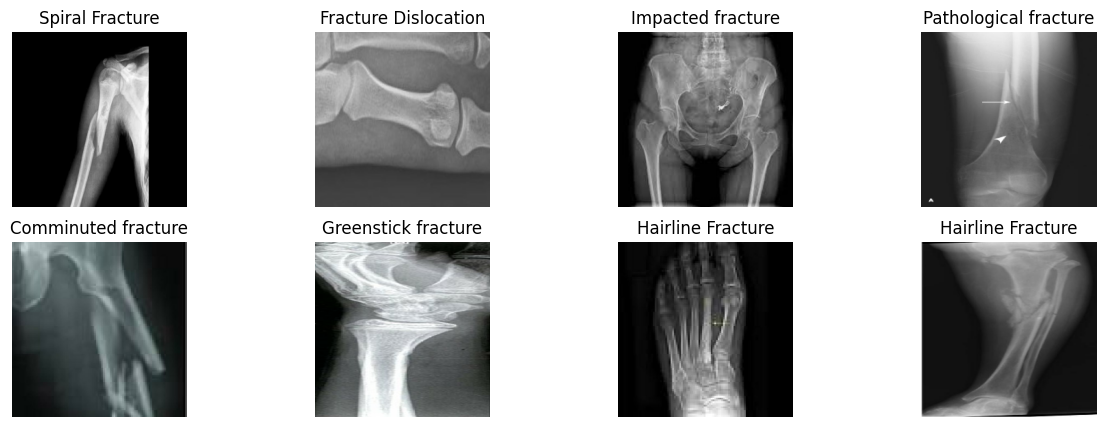

In [ ]:
class_labels=["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]
# Initialize the figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 5))

# Iterate through the first 10 images
for i, ax in enumerate(axes.flat):
    # Select the image and label
    image, label = train_x[i], train_y[i]

    # Display the image
    ax.imshow(image, cmap='gray')

    # Set the title with the class label
    ax.set_title(f"{class_labels[np.argmax(label)]}")
    ax.axis('off')

# Display the figure
plt.show()

# **Model**

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(60, (3, 3), activation='relu', input_shape=(256, 256, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(120, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 60)        │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 60)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 120)       │          64,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 461280)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │      18,451,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,518,250 (70.64 MB)

 Trainable params: 18,518,250 (70.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(train_x, train_y, batch_size=10, epochs=5,
          validation_data=(val_x,val_y))

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.1239 - loss: 3.3760 - val_accuracy: 0.1554 - val_loss: 2.2722
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1728 - loss: 2.2833 - val_accuracy: 0.3697 - val_loss: 2.0003
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.3806 - loss: 1.8714 - val_accuracy: 0.6273 - val_loss: 1.3446
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6250 - loss: 1.2207 - val_accuracy: 0.8673 - val_loss: 0.6911
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8098 - loss: 0.7007 - val_accuracy: 0.9213 - val_loss: 0.3635


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_x,val_y)
print('Test accuracy:', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9256 - loss: 0.3377
Test accuracy: 0.9213372468948364


In [ ]:
pred = model.predict(val_x)
print(pred)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
[[1.9590891e-08 1.1078599e-12 3.5846233e-06 ... 9.9999642e-01
  3.9778689e-13 1.0792399e-13]
 [2.2107523e-02 8.1962633e-01 8.7477295e-03 ... 1.2605882e-02
  3.3745640e-03 6.3028173e-03]
 [8.1816196e-08 1.9113374e-13 1.3798886e-14 ... 3.4532494e-10
  9.9999988e-01 3.7963288e-10]
 ...
 [5.7951760e-02 2.4204515e-03 2.0143295e-04 ... 5.3242390e-04
  1.2978795e-03 1.8411944e-05]
 [1.9747250e-02 3.0091667e-04 7.6495082e-05 ... 7.7963137e-04
  9.5970130e-01 2.1335401e-04]
 [1.4180024e-01 7.0337388e-03 6.3503581e-01 ... 8.8387541e-02
  1.0060550e-02 3.6985874e-03]]


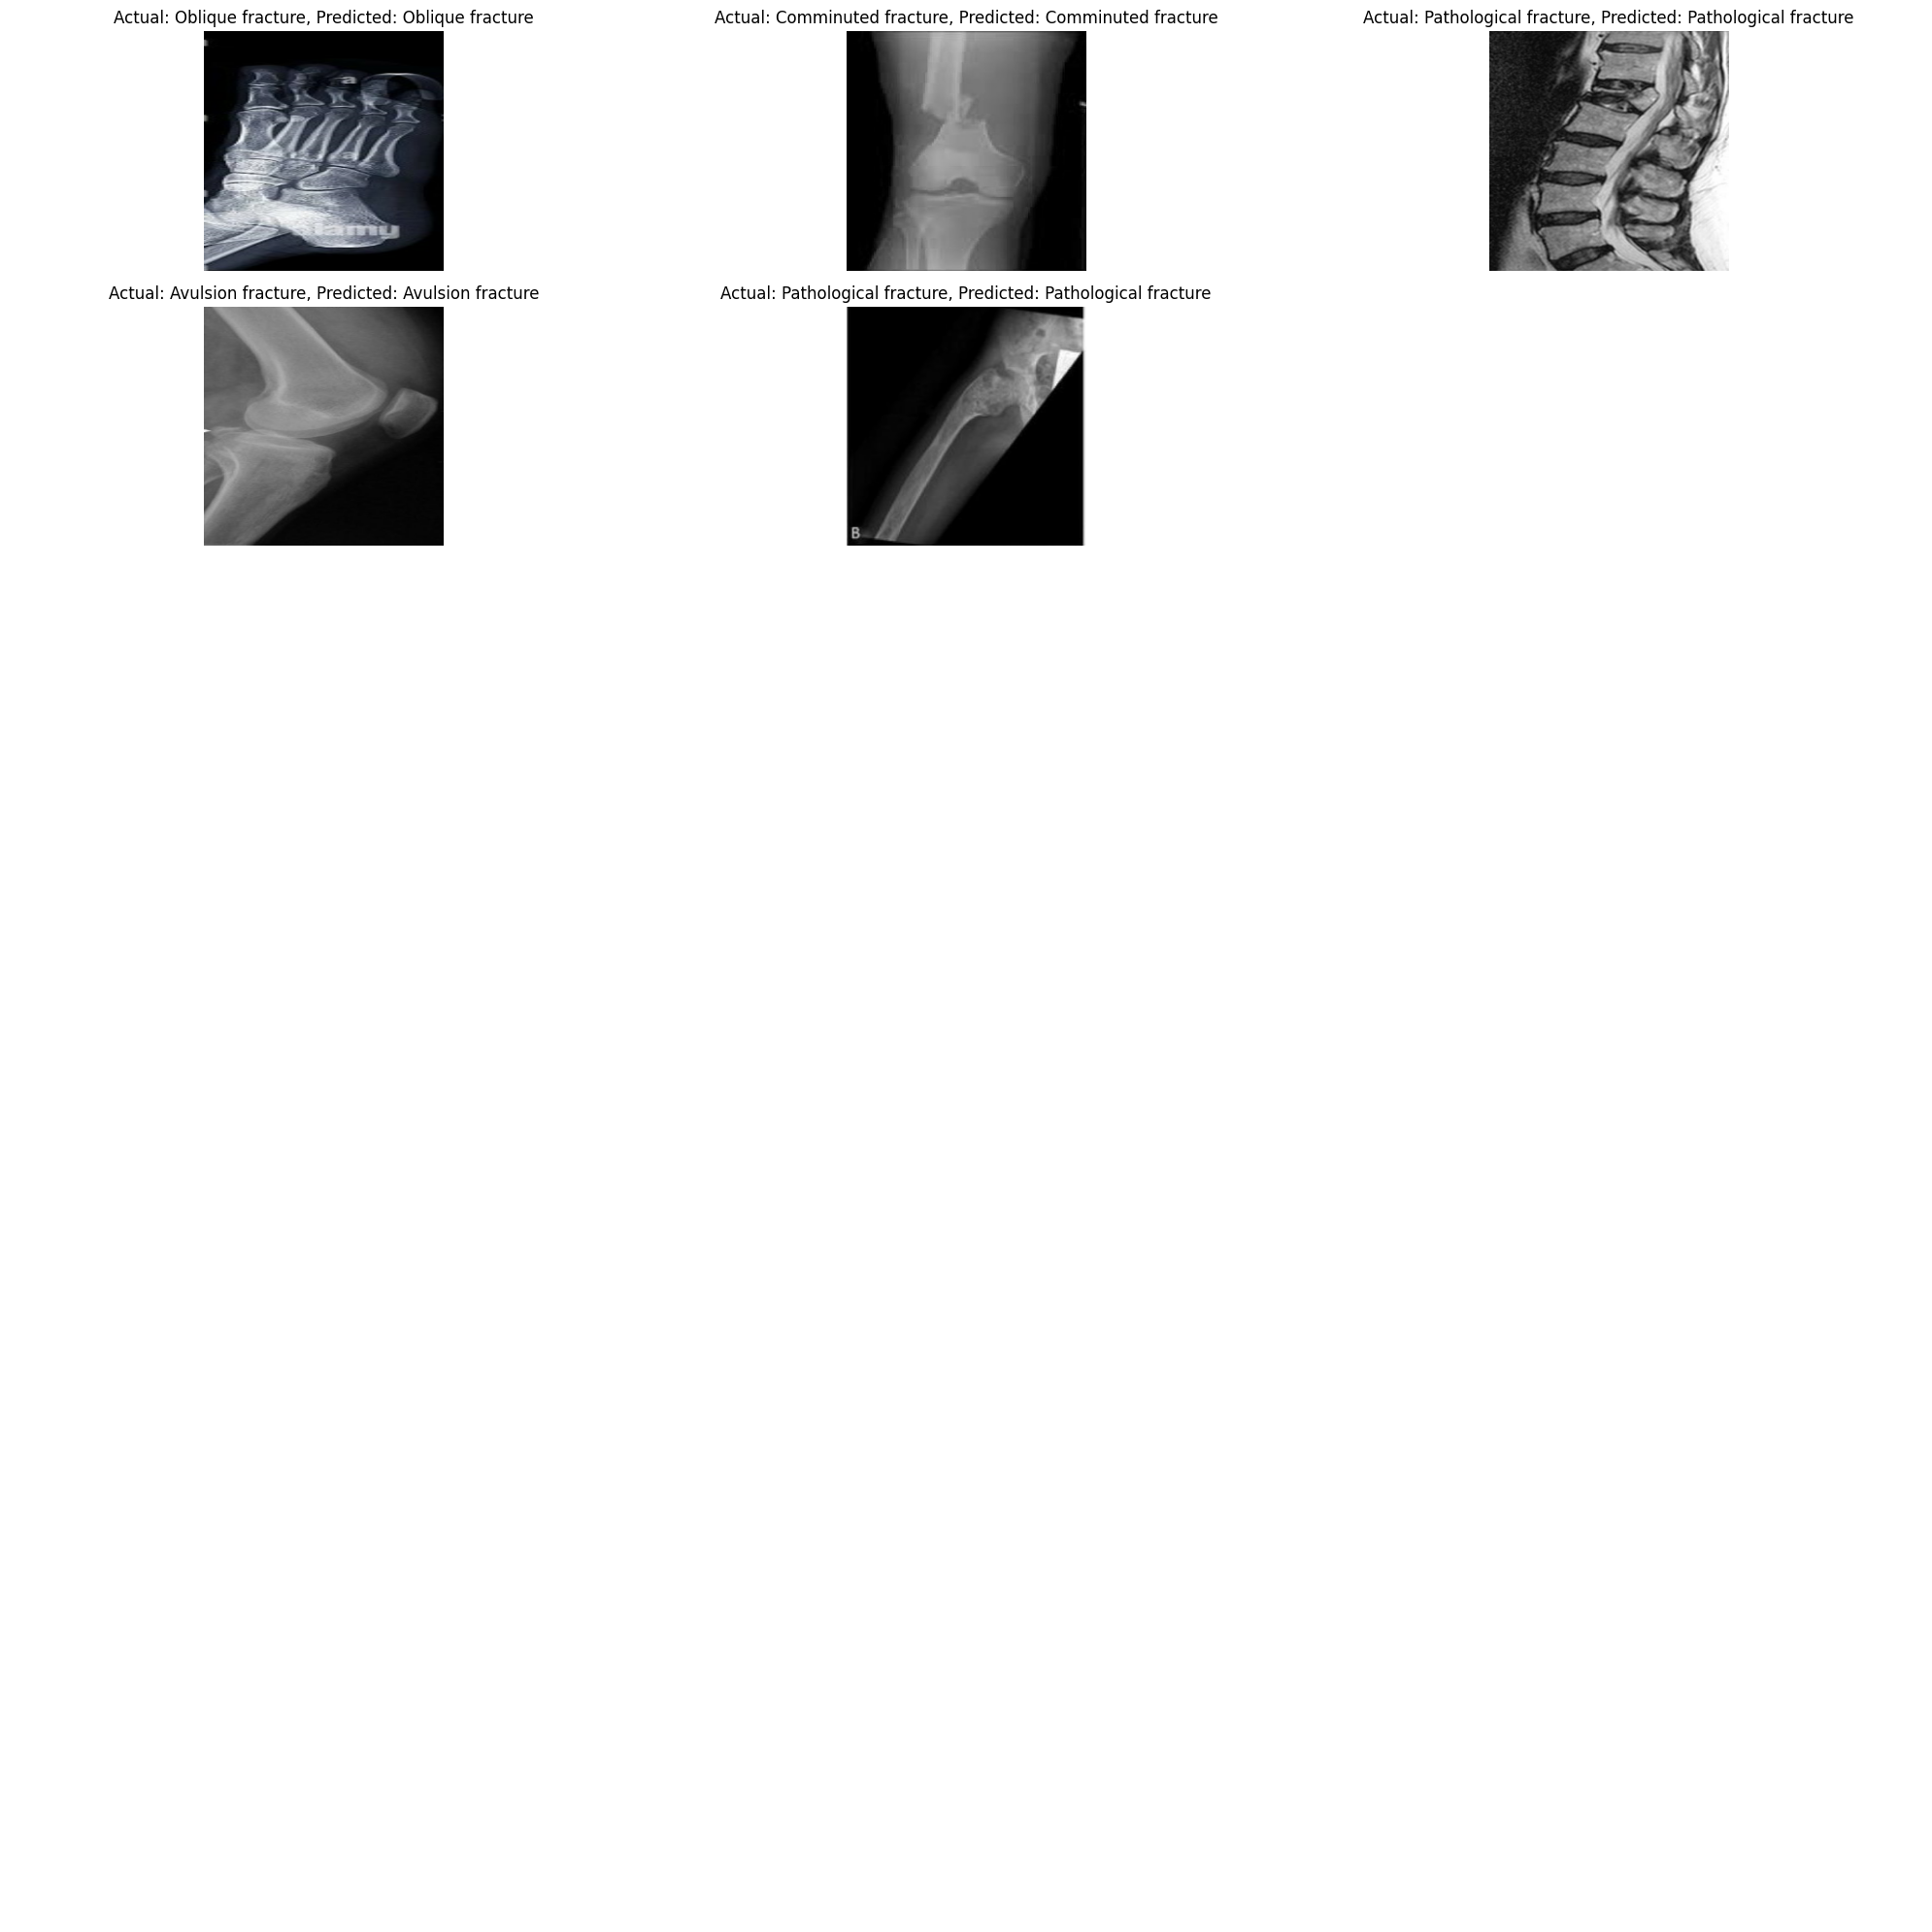

In [ ]:
num_images_to_display = 5
num_columns = 3
num_rows = (num_images_to_display + num_columns - 1)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        ax.imshow(val_x[i])
        actual_label = class_labels[np.argmax(val_y[i])]
        predicted_label = class_labels[np.argmax(pred[i])]
        ax.set_title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
